In [1]:
%matplotlib inline

import json
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, Isomap
from MulticoreTSNE import MulticoreTSNE
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA, SparsePCA
import umap
from scipy.sparse import vstack
import pandas as pd
from gb_writer import GlyphboardWriter
# from sklearn.model_selection import GridSearchCV
from typing import Any
import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import spacy
from spacy.lang.de.stop_words import STOP_WORDS


nlp = spacy.load('de')

C:\Users\ducanh.trinh\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


In [2]:
# Classifiers
SGD = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,
                    random_state=42, max_iter=5, tol=None)
MNB = MultinomialNB()
LR = LogisticRegression()
SVC = LinearSVC()
KNC = KNeighborsClassifier()
NC = NearestCentroid()
RFC = RandomForestClassifier()

vec = TfidfVectorizer(strip_accents='ascii', max_df=0.5, sublinear_tf=True)
SPLICE_POINT = 800
UNLABELED_VALUE = -1

In [19]:
def init():
    print('Updating JSON...')
    updateDatasetJson()
    # print('Cleaning Texts...')
    # cleanupTexts()
    print('Done')

def mockInit():
    texts = []
    labels = []
    ids = []
    peer_labels = []
    with open("test_data.json", "r") as read_file:
        LC_data = json.load(read_file)

    for doc in LC_data:
        ids.append(doc['id'])
        texts.append(doc["values"]["7"])
        peer_labels.append(doc["features"]["1"]["4"])
        # simulate all as labeled (for test_data)
        if (doc["features"]["1"]["4"] > 0.5):
            labels.append(1)
        else:
            labels.append(0)

    df = pd.DataFrame({
        'id': ids,
        'text': texts,
        'label': labels,
        'peer_label': peer_labels,
        'score': [0] * len(LC_data),
        'isLabeled': [0]  * len(LC_data),
        'entities': [' '] * len(LC_data)
    })
   
    test_data = df[SPLICE_POINT+1:]
    saveData(test_data, 'test_data')
    # test_data.to_csv('test_data.csv', sep=";", encoding="utf8", index=False)
    data_with_scores = getSelectionScores(rest_data=df, train_data=test_data)
    saveData(data_with_scores)
    resetTrainData()
    
    # data_with_scores.to_csv('data.csv', sep=";", encoding="utf8", index=False)
    # resetTrainData()

def loadData(name = 'data'):
    return pd.read_csv('{}.csv'.format(name), sep=";", encoding="utf-8")

def saveData(data, name = 'data'):
    with open('{}.csv'.format(name), mode='w', newline='\n', encoding='utf-8') as f:
        data.to_csv(f, sep=";", line_terminator='\n', encoding='utf-8', index=False)
    # data.to_csv('mlbackend/{}.csv'.format(name), sep=";", encoding="utf-8", index=False)

def handleNewAnswer(answer):
    newAnswer = {
        'text': answer['text'],
        'docId': answer['documentId'],
        'label': int(answer['answer']),
        'question': answer['questionId']
    }
    train_data = getTrainData()

    test_data = getTestData()
    
    data = updateDataWithLabel(loadData(), newAnswer['docId'], newAnswer['label'])
    if len(train_data) > 3:
        # tfidf = vec.fit_transform(data.text)        
        # positions = applyDR(tfidf, withPreviousPos=False, labels=data.label)
        # writer = GlyphboardWriter('test_name')
        # position_response = writer.write_position(positions=positions, algorithm='umap')
        train_result = train(train_data, test_data, SGD)
        return {
            # 'positions': position_response,
            'train_result': train_result
        }
    else:
        return ''

def handleCompleteUpdate():
    data = loadData()
    # updateDatasetJson()
    tfidf = vec.fit_transform(data.text)
    positions = applyDR(tfidf, withPreviousPos=True, labels=data.label)
    writer = GlyphboardWriter('test_name')
    position_response = writer.write_position(positions=positions, algorithm='umap')
    return position_response

def updateDatasetJson():
    with open("test_data.json", "r") as read_file:
        LC_data = json.load(read_file)
        
    data = loadData()

    for doc in LC_data:
        doc['features']['1']['31'] = int(data.loc[data['id'] == doc['id']].isLabeled.values[0])
        doc['values']['31'] = int(data.loc[data['id'] == doc['id']].isLabeled.values[0])
        doc['features']['1']['32'] = float(data.loc[data['id'] == doc['id']].score.values[0])
        doc['values']['32'] = float(data.loc[data['id'] == doc['id']].score.values[0])
        doc['features']['1']['33'] = int(data.loc[data['id'] == doc['id']].label.values[0])
        doc['values']['33'] = int(data.loc[data['id'] == doc['id']].label.values[0])
        doc['features']['1']['34'] = str(data.loc[data['id'] == doc['id']].entities.values[0])
        doc['values']['34'] = str(data.loc[data['id'] == doc['id']].entities.values[0])

    with open("../backend/data/mainTfIdf/mainTfIdf.05112018.feature.json", "w") as f:
            json.dump(LC_data, f)
    
    return 'Done'

def updateDataWithLabel(data, docId, label):
    print('before', data.loc[data['id'] == docId])
    data.loc[data['id'] == docId, 'label'] = int(label)
    data.loc[data['id'] == docId, 'isLabeled'] = 1
    print('after', data.loc[data['id'] == docId])
    saveData(data)

    return data


def createMetrics(algo, train_data):
    test_data = getTestData()
    met = []
    # Create stepwise metrics algo, simulating a history
    for number in range(30, len(train_data)):
        train_data_iteration = train_data.head(number)
        met.append(train(train_data_iteration, test_data, algo=algo))
    return pd.DataFrame(met)


def train(train_data, test_data, algo: Any) -> dict:
    text_clf = Pipeline([
        # ('vect', CountVectorizer()),
        ('tfidf', vec),
        ('clf', algo),
    ])
    text_clf.fit(train_data.text, train_data.label)
    predicted = text_clf.predict(test_data.text)
    addHistory(metrics.f1_score(test_data.label, predicted))
    result = {
        'precision': metrics.precision_score(test_data.label, predicted),
        'recall': metrics.recall_score(test_data.label, predicted),
        'f1': metrics.f1_score(test_data.label, predicted),
        'f1_history': getHistory()
    }
    return result

def getTrainData():
    data = loadData()
    return data.loc[data['isLabeled'] == 1]

def getTestData():
    return pd.read_csv('test_data.csv', delimiter=';', encoding="utf8")

def resetTrainData():
    data = loadData()
    data.loc[:, 'label'] = UNLABELED_VALUE
    data.loc[:, 'isLabeled'] = 0
    saveData(data)

def cleanupTexts():
    data = loadData()
    for idx, text in enumerate(data.text):
        data.loc[idx, 'text'] = preprocessText(text)
        data.loc[idx, 'entities'] = extractNER(text)
        
    saveData(data)

def mockTraining(amount):
    data = loadData()
    for i in range(amount):
        data.loc[i, 'isLabeled'] = 1
        if data.loc[i].peer_label > 0.5:
            data.loc[i, 'label'] = 1
        else:
            data.loc[i, 'label'] = 0        
    saveData(data)

def simulateTraining(iterations):
    test_data = getTestData()
    mockTraining(iterations)
    train_data = getTrainData()
    train(train_data, test_data, SGD)

def getHistory():
    history = []
    with open(
            "metrics.csv", "r", encoding="utf8") as file:
        reader = csv.reader(file, delimiter=';')
        for line in reader:
            history.append(line[0])
        file.close()
    return history


def addHistory(metrics):
    with open(
            "metrics.csv", "a",  newline="", encoding="utf8") as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow([str(metrics)])
        file.close()

def getCurrentScore() -> int:
    return getHistory().pop()

def applyDR(tfidf, labels = [], withPreviousPos = True, factor = 1):    
    # pre_computed = TruncatedSVD(n_components=100, random_state=1).fit_transform(tfidf.toarray())
    # LABEL_IMPACT = 0
    if withPreviousPos:        
        previousPositions = loadData('previousPositions').values
    else:
        previousPositions = 'spectral'
    labels_arr = np.asarray(labels)
    labels_arr = labels_arr.reshape(len(labels_arr), 1)
    # with_labels = np.hstack((tfidf.toarray(), labels_arr))
    computed_coords = umap.UMAP(init=previousPositions,min_dist=0.8, random_state=1, learning_rate=0.5).fit(tfidf.toarray(), y=labels_arr)
    computed_coords = computed_coords.embedding_
    saveData(pd.DataFrame(computed_coords), 'previousPositions')
    computed_coords *= factor    
    # computed_coords = MulticoreTSNE(n_jobs=4, random_state=1).fit_transform(with_labels)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = computed_coords[:, 0]
    df['y'] = computed_coords[:, 1]
    
    return df

def preprocessText(text: str) -> str:
    # print('Original: ', text)
    doc = nlp(text)
    # Remove Stop Words and get Lemmas
    return ' '.join([token.text for token in doc if not token.is_stop])
    
def extractNER(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        cleaned = ent.text.replace('\r', '')
        cleaned = cleaned.replace('\n', '')
        entities.append(cleaned)
    if (len(entities) > 0):
        return ', '.join(entities)
    else:
        return ''

def getSelectionScores(rest_data, train_data, clf = MNB): 
    text_clf = Pipeline([
        # ('vect', CountVectorizer()),
        ('tfidf', vec),
        ('clf', clf),
    ])
    text_clf.fit(train_data.text, train_data.label)
    prs = text_clf.predict_proba(rest_data.text) 
    result_pos = [1-2*abs(x[1]-0.5)  for x in prs]
    rest_data['score'] = result_pos
    return rest_data

def analyseImportantFeatures(clf=SGD):
    train_data = getTrainData()
    tfidf = vec.fit_transform(train_data.text)
    clf.fit(tfidf, train_data.label)
    feature_names = vec.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print('\t%.4f\t%-15s\t\t%.4f\t%-15s' % (coef_1, fn_1, coef_2, fn_2))

In [18]:
# mock everything for demo
data = loadData()
test_data = getTestData()
saveData(getSelectionScores(data, test_data))
resetTrainData()
mockTraining(10)
updateDatasetJson()

'Done'

In [17]:
# Check important features of classification
# cleanupTexts()
train_data = getTrainData()
tfidf = vec.fit_transform(train_data.text)
clf = SGD
clf.fit(tfidf, train_data.label)
feature_names = vec.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
top = zip(coefs_with_fns[:20], coefs_with_fns[:-(20 + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ('\t%.4f\t%-15s\t\t%.4f\t%-15s' % (coef_1, fn_1, coef_2, fn_2))


	-1.0437	anmeldung      		4.3675	musik          
	-0.9557	events         		3.8557	dj             
	-0.9185	spiele         		2.4609	konzert        
	-0.9034	17             		2.2761	band           
	-0.8916	bitte          		2.0712	live           
	-0.8669	film           		1.9368	songs          
	-0.8374	glucksrad      		1.9098	rock           
	-0.6973	tag            		1.7798	karaoke        
	-0.6957	stammtisch     		1.7188	music          
	-0.6886	kinder         		1.3963	jazz           
	-0.6879	treffen        		1.3606	hits           
	-0.6570	vortrag        		1.3335	musikalische   
	-0.6440	menschen       		1.3319	weihnachtskonzert
	-0.6413	fuhrung        		1.2936	sound          
	-0.6368	was            		1.2929	hop            
	-0.6306	rumanischer    		1.2814	eintritt       
	-0.6069	montag         		1.2470	klavier        
	-0.6052	2013           		1.2392	musiker        
	-0.5941	lesung         		1.2294	musikalischer  
	-0.5917	jeder          		1.1907	90er           


In [8]:
resetTrainData()
mockTraining(100)
train_data = getTrainData()
SGD_AL = createMetrics(SGD, train_data.sort_values(by='score', ascending=False))

In [449]:

# resetTrainData()
# mockTraining(300)
train_data = getTrainData()
SGD_met = createMetrics(SGD, train_data)
# MNB_met = createMetrics(MNB)
# KNC_met = createMetrics(KNC)
# NC_met = createMetrics(NC)
# RFC_met = createMetrics(RFC)
# getTrainData()


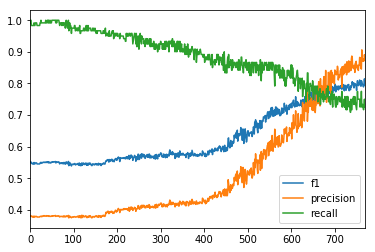

In [467]:
SGD_AL.plot()

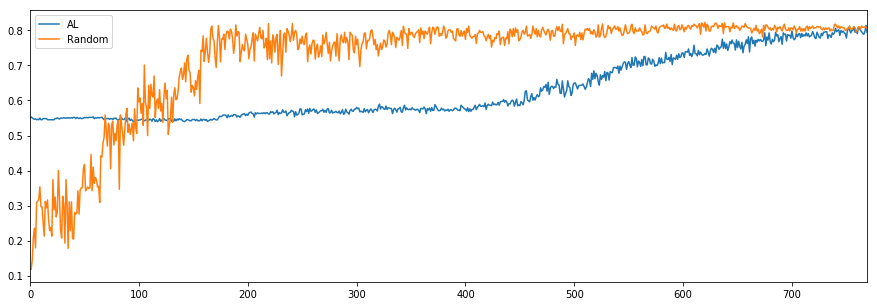

In [450]:
pd.DataFrame({'Random': SGD_met.f1, 'AL': SGD_AL.f1}).plot(figsize=(15, 5))

In [462]:
# cleanupTexts()
loadData()
mockTraining(300)

In [477]:
# cleanupTexts()
# loadData().entities
updateDatasetJson()

'Done'

In [426]:
data = loadData()
train_data = getTrainData()
test_data = getTestData()
data = getSelectionScores(data, test_data, clf=SGDClassifier(loss='log'))
saveData(data)
train_data = getTrainData()
train_data.sort_values(by='score', ascending=False)

C:\Users\ducanh.trinh\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


,id,isLabeled,label,peer_label,score,text,entities
124,125,1,1,0.562500,0.997647,Salsa-Night Los Chicos ! Am 27.02 findet C'est...,"Salsa-Night Los Chicos !, C'est la Vie Salsani..."
282,283,1,0,0.125000,0.995372,LIQUID BRUNCH with SHREDDER KILL YOUR HANGOVER...,"LIQUID, SHREDDER, SHREDDER and the, FREE"
435,436,1,0,0.000000,0.990726,Friday Night Magic Boosterdraft Format Draft,Friday Night Magic
477,478,1,1,1.000000,0.983364,Hubsn Creative pres . BASS FEVER with NICKY BL...,"Hubsn Creative pres, BASS, FEVER, NICKY, FEVER..."
217,218,1,0,0.500000,0.983093,Die ultimative Tanzshow - FAMILY BOOK Tanzschu...,"Tanzshow, FAMILY, FAMILY BOOK, Auditorium Maxi..."
17,18,1,0,0.000000,0.977036,Spielinsel Mannheim Weitere Infos 's Seite htt...,Spielinsel Mannheim
320,321,1,1,0.843750,0.974880,Peter Pan - Musical Das Musical-Abenteuer Fami...,"Peter Pan, Das Musical-Abenteuer Familie Junge..."
455,456,1,0,0.156250,0.953204,Halloween@Dudes4 Fette Fette Halloween Sause !...,"Mitternacht, Dudes !"
186,187,1,1,1.000000,0.944634,"Nikolausrave Hoo , hoo , hoo miteinander ! ! \...","Nikolausrave Hoo, Weihnachten, Zeit, , ..."
250,251,1,0,0.000000,0.940735,H2O Swimming trip Swimming at H2O Herford,"H2O Swimming, Swimming at H2O"


In [5]:
getTrainData().sort_values(by='score', ascending=False)

,entities,id,isLabeled,label,peer_label,score,text
392,"Finkenwerder JamSession, Andy Plath Finkenwerd...",393,1,1,0.968750,0.998023,9 . Finkenwerder JamSession Fred Kröger Andy P...
335,"Après-Ski Party Vol., Après-Ski Party Volume 3...",336,1,1,1.000000,0.996844,Après-Ski Party Vol. 3 Am 27 . Februar soweit ...
294,"GARDENS END Sommerspecial, Gardens End, Liebli...",295,1,1,1.000000,0.993937,GARDENS END Sommerspecial - Die Rockband Garde...
340,"PSYCHEDELIC TOURNAMENT, Facebook, ¦, ACTS, ¦, ...",341,1,1,0.967742,0.990659,? PSYCHEDELIC TOURNAMENT ? Leider Dank Faceboo...
224,"OUR, RECORD TABLE, ANYONE, MUM & DAD, Record T...",225,1,1,0.906250,0.989008,OUR LABEL RECORD TABLE - vinyl sale BLACK BEAU...
207,"Wort Bild Hanns Friedrich Arnold, Hanns Friedr...",208,1,0,0.218750,0.985771,Poesie Wort Bild Hanns Friedrich Arnold ( Rezi...
259,"Renate Bojanowski, ● , Georg Philipp Teleman...",260,1,1,0.903226,0.985463,Von Renate Bojanowski \r\n Magdeburg \r\n ...
239,"Jamie Hill &, Peter Ray, Jamie Hill Peter Ray ...",240,1,1,1.000000,0.982494,Live-Musik : Jamie Hill & Peter Ray Wir begrüs...
244,"Indersdorfer, Areas 2, Holzfass !, Freibier...",245,1,1,0.935484,0.981610,3 . Indersdorfer Faschingsball Nach Erfolg 201...
101,"Silvester-Party Bistro Antalya, Bautzen Feiert...",102,1,1,0.906250,0.980648,"Silvester-Party Bistro Antalya , Bautzen Feier..."
